# Manual Interval Binning with binlearn

This notebook demonstrates **ManualIntervalBinning**, which creates bins using explicitly provided bin edges. Unlike automatic binning methods, this gives users complete control over binning boundaries, making it ideal for:

- **Standardized binning** across multiple datasets
- **Domain-specific requirements** with business rules
- **Regulatory compliance** where specific bins are mandated
- **Reproducible binning** with known boundaries

We'll explore different use cases including business intelligence, medical diagnostics, and financial risk assessment.

## 1. Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from binlearn.methods import ManualIntervalBinning

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Basic Usage - Business Intelligence Example

Let's start with a business scenario where we need standardized customer segmentation bins across different datasets.

In [2]:
# Create business customer data
customer_data = pd.DataFrame({
    'age': np.random.normal(40, 15, 1000).clip(18, 80),
    'income': np.random.lognormal(10.5, 0.8, 1000).clip(20000, 200000),
    'credit_score': np.random.normal(650, 100, 1000).clip(300, 850)
})

# Define standardized business bin edges
business_edges = {
    'age': [18, 25, 35, 50, 65, 80],          # Age demographics
    'income': [0, 30000, 60000, 100000, 200000],  # Income brackets
    'credit_score': [300, 580, 670, 740, 850]     # Credit categories
}

# Define meaningful labels for business interpretation (these will be used for display)
business_labels = {
    'age': ['Young Adult', 'Early Career', 'Mid Career', 'Pre-Retirement'],
    'income': ['Low Income', 'Middle Income', 'High Income', 'Premium'],
    'credit_score': ['Poor Credit', 'Fair Credit', 'Good Credit', 'Excellent Credit']
}

# Apply manual interval binning (without string representatives for now)
binner = ManualIntervalBinning(
    bin_edges=business_edges,
    preserve_dataframe=True,
    clip=True  # Handle outliers by clipping to nearest bin
)

customer_binned = binner.fit_transform(customer_data)

print("Original vs Binned Customer Data:")
print("\nOriginal data sample:")
print(customer_data.head())
print("\nBinned data sample:")
print(customer_binned.head())

# Show distribution of customers across segments
print("\nCustomer Distribution by Segment:")
for column in customer_binned.columns:
    print(f"\n{column.title()}:")
    counts = customer_binned[column].value_counts().sort_index()
    for i, count in counts.items():
        label = business_labels[column][i] if i < len(business_labels[column]) else f"Bin {i}"
        percentage = count / len(customer_data) * 100
        print(f"  {label}: {count} customers ({percentage:.1f}%)")

Original vs Binned Customer Data:

Original data sample:
         age         income  credit_score
0  47.450712  111244.342997    582.482173
1  37.926035   76092.649284    635.548133
2  49.715328   38089.894737    570.758008
3  62.845448   21643.286173    619.203847
4  36.487699   63486.251580    460.638533

Binned data sample:
   age  income  credit_score
0    2       3             1
1    2       2             1
2    2       1             0
3    3       0             1
4    2       2             0

Customer Distribution by Segment:

Age:
  Young Adult: 147 customers (14.7%)
  Early Career: 221 customers (22.1%)
  Mid Career: 389 customers (38.9%)
  Pre-Retirement: 191 customers (19.1%)
  Bin 4: 52 customers (5.2%)

Income:
  Low Income: 369 customers (36.9%)
  Middle Income: 351 customers (35.1%)
  High Income: 169 customers (16.9%)
  Premium: 111 customers (11.1%)

Credit_Score:
  Poor Credit: 233 customers (23.3%)
  Fair Credit: 338 customers (33.8%)
  Good Credit: 262 customers (26

## 3. Domain-Specific Example - Medical Diagnostics

Medical applications often require specific clinical thresholds for diagnostic categories.

In [3]:
# Generate medical test data
medical_data = pd.DataFrame({
    'bmi': np.random.normal(25, 5, 800).clip(15, 45),
    'blood_pressure_systolic': np.random.normal(125, 20, 800).clip(90, 200),
    'cholesterol': np.random.normal(200, 40, 800).clip(150, 350),
    'blood_sugar_fasting': np.random.normal(95, 15, 800).clip(70, 150)
})

# Clinical threshold-based bin edges (based on medical guidelines)
clinical_edges = {
    'bmi': [0, 18.5, 25, 30, 40],                         # BMI categories
    'blood_pressure_systolic': [0, 120, 130, 140, 180, 300],  # BP stages
    'cholesterol': [0, 200, 240, 300],                    # Cholesterol levels
    'blood_sugar_fasting': [0, 100, 126, 200]            # Diabetes screening
}

# Medical category labels (for display purposes)
medical_labels = {
    'bmi': ['Underweight', 'Normal', 'Overweight', 'Obese'],
    'blood_pressure_systolic': ['Normal', 'Elevated', 'Stage 1', 'Stage 2', 'Crisis'],
    'cholesterol': ['Desirable', 'Borderline High', 'High'],
    'blood_sugar_fasting': ['Normal', 'Pre-diabetic', 'Diabetic']
}

# Apply medical binning (without string representatives)
medical_binner = ManualIntervalBinning(
    bin_edges=clinical_edges,
    preserve_dataframe=True,
    clip=True
)

medical_binned = medical_binner.fit_transform(medical_data)

print("Medical Diagnostic Categories:")
print("\nPatient Health Profile Distribution:")
for feature in medical_data.columns:
    print(f"\n{feature.replace('_', ' ').title()}:")
    counts = medical_binned[feature].value_counts().sort_index()
    for i, count in counts.items():
        label = medical_labels[feature][i] if i < len(medical_labels[feature]) else f"Category {i}"
        percentage = count / len(medical_data) * 100
        print(f"  {label}: {count} patients ({percentage:.1f}%)")

# Risk assessment example
risk_indicators = (
    (medical_binned['bmi'] >= 2) +  # Overweight or obese
    (medical_binned['blood_pressure_systolic'] >= 2) +  # Stage 1+ hypertension
    (medical_binned['cholesterol'] >= 1) +  # Borderline high+ cholesterol
    (medical_binned['blood_sugar_fasting'] >= 1)  # Pre-diabetic+
)

print("\nCardiovascular Risk Assessment:")
risk_counts = risk_indicators.value_counts().sort_index()
risk_labels = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk', 'Critical Risk']
for risk_level, count in risk_counts.items():
    label = risk_labels[risk_level] if risk_level < len(risk_labels) else f"Risk Level {risk_level}"
    percentage = count / len(medical_data) * 100
    print(f"  {label}: {count} patients ({percentage:.1f}%)")

Medical Diagnostic Categories:

Patient Health Profile Distribution:

Bmi:
  Underweight: 79 patients (9.9%)
  Normal: 318 patients (39.8%)
  Overweight: 260 patients (32.5%)
  Obese: 143 patients (17.9%)

Blood Pressure Systolic:
  Normal: 337 patients (42.1%)
  Elevated: 154 patients (19.2%)
  Stage 1: 139 patients (17.4%)
  Stage 2: 168 patients (21.0%)
  Crisis: 2 patients (0.2%)

Cholesterol:
  Desirable: 403 patients (50.4%)
  Borderline High: 283 patients (35.4%)
  High: 114 patients (14.2%)

Blood Sugar Fasting:
  Normal: 524 patients (65.5%)
  Pre-diabetic: 259 patients (32.4%)
  Diabetic: 17 patients (2.1%)

Cardiovascular Risk Assessment:
  Low Risk: 77 patients (9.6%)
  Moderate Risk: 723 patients (90.4%)


## 4. Visualization of Binning Effects

Let's visualize how manual interval binning transforms continuous distributions into discrete categories.

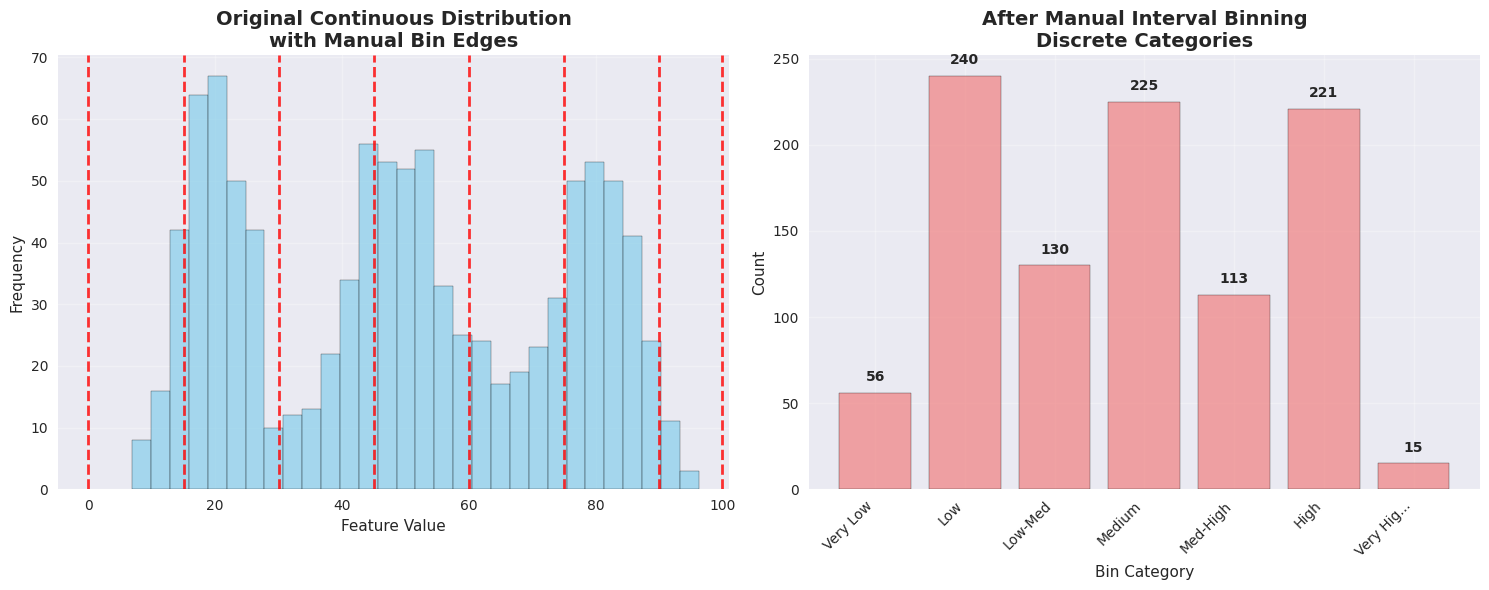

Binning Transformation Summary:
Original data range: 6.9 to 96.3
Number of unique values: 1000
After binning: 7 discrete categories
Bin edges used: [0, 15, 30, 45, 60, 75, 90, 100]


In [4]:
# Create sample data for visualization
viz_data = pd.DataFrame({
    'continuous_feature': np.concatenate([
        np.random.normal(20, 5, 300),
        np.random.normal(50, 8, 400),
        np.random.normal(80, 6, 300)
    ])
})

# Define custom bin edges for visualization
viz_edges = {
    'continuous_feature': [0, 15, 30, 45, 60, 75, 90, 100]
}

viz_labels = {
    'continuous_feature': ['Very Low', 'Low', 'Low-Med', 'Medium', 'Med-High', 'High', 'Very High']
}

# Apply binning (without string representatives)
viz_binner = ManualIntervalBinning(
    bin_edges=viz_edges,
    preserve_dataframe=True
)

viz_binned = viz_binner.fit_transform(viz_data)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original continuous distribution
ax1.hist(viz_data['continuous_feature'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axhline(y=0, color='black', linewidth=0.5)

# Add vertical lines for bin edges
for edge in viz_edges['continuous_feature']:
    ax1.axvline(x=edge, color='red', linestyle='--', alpha=0.8, linewidth=2)

ax1.set_title('Original Continuous Distribution\nwith Manual Bin Edges', fontsize=14, fontweight='bold')
ax1.set_xlabel('Feature Value')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Binned distribution
bin_counts = viz_binned['continuous_feature'].value_counts().sort_index()
bin_labels_short = [label[:8] + '...' if len(label) > 8 else label for label in viz_labels['continuous_feature']]

bars = ax2.bar(range(len(bin_counts)), bin_counts.values, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_title('After Manual Interval Binning\nDiscrete Categories', fontsize=14, fontweight='bold')
ax2.set_xlabel('Bin Category')
ax2.set_ylabel('Count')
ax2.set_xticks(range(len(bin_counts)))
ax2.set_xticklabels(bin_labels_short, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, bin_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Binning Transformation Summary:")
print(f"Original data range: {viz_data['continuous_feature'].min():.1f} to {viz_data['continuous_feature'].max():.1f}")
print(f"Number of unique values: {viz_data['continuous_feature'].nunique()}")
print(f"After binning: {len(bin_counts)} discrete categories")
print(f"Bin edges used: {viz_edges['continuous_feature']}")

## 5. Consistency Across Datasets

One key advantage of manual binning is ensuring consistent binning across different datasets.

In [5]:
# Create two different datasets with different distributions
np.random.seed(100)
dataset1 = pd.DataFrame({
    'feature1': np.random.normal(30, 10, 500),
    'feature2': np.random.exponential(2, 500)
})

np.random.seed(200)
dataset2 = pd.DataFrame({
    'feature1': np.random.normal(45, 15, 500),  # Different mean/std
    'feature2': np.random.exponential(3, 500)   # Different scale
})

# Fixed bin edges ensure consistency across datasets
standard_edges = {
    'feature1': [0, 20, 35, 50, 65, 80],
    'feature2': [0, 1, 3, 6, 10, 15]
}

# Apply same binning to both datasets
consistency_binner = ManualIntervalBinning(
    bin_edges=standard_edges,
    preserve_dataframe=True,
    clip=True
)

dataset1_binned = consistency_binner.fit_transform(dataset1)
dataset2_binned = consistency_binner.transform(dataset2)  # No fitting needed

print("Consistency Analysis Across Different Datasets:")
print("\nDataset 1 vs Dataset 2 - Feature 1 Distribution:")

feature1_dist1 = dataset1_binned['feature1'].value_counts().sort_index()
feature1_dist2 = dataset2_binned['feature1'].value_counts().sort_index()

print(f"{'Bin':<8} {'Dataset1 %':<12} {'Dataset2 %':<12} {'Difference':<12}")
print("-" * 48)
for bin_idx in range(max(feature1_dist1.index.max(), feature1_dist2.index.max()) + 1):
    count1 = feature1_dist1.get(bin_idx, 0)
    count2 = feature1_dist2.get(bin_idx, 0)
    pct1 = count1 / len(dataset1) * 100
    pct2 = count2 / len(dataset2) * 100
    diff = abs(pct1 - pct2)
    print(f"{bin_idx:<8} {pct1:<12.1f} {pct2:<12.1f} {diff:<12.1f}")

print("\nDespite different underlying distributions, we get:")
print("✓ Consistent bin definitions across datasets")
print("✓ Comparable categorical representations")
print("✓ Reproducible binning for model deployment")

# Show the original distributions were indeed different
print(f"\nOriginal data statistics:")
print(f"Dataset 1 Feature 1: mean={dataset1['feature1'].mean():.1f}, std={dataset1['feature1'].std():.1f}")
print(f"Dataset 2 Feature 1: mean={dataset2['feature1'].mean():.1f}, std={dataset2['feature1'].std():.1f}")

Consistency Analysis Across Different Datasets:

Dataset 1 vs Dataset 2 - Feature 1 Distribution:
Bin      Dataset1 %   Dataset2 %   Difference  
------------------------------------------------
0        18.0         4.6          13.4        
1        51.0         19.6         31.4        
2        28.0         37.0         9.0         
3        3.0          29.6         26.6        
4        0.0          9.2          9.2         

Despite different underlying distributions, we get:
✓ Consistent bin definitions across datasets
✓ Comparable categorical representations
✓ Reproducible binning for model deployment

Original data statistics:
Dataset 1 Feature 1: mean=29.9, std=10.3
Dataset 2 Feature 1: mean=45.4, std=14.9


## 6. Integration with Scikit-learn Pipelines

Manual interval binning integrates seamlessly with scikit-learn pipelines for machine learning workflows.

In [6]:
# Create classification dataset
X, y = make_classification(
    n_samples=2000, 
    n_features=4, 
    n_informative=3,
    n_redundant=1,
    n_classes=2, 
    random_state=42
)

# Define standardized bin edges for ML pipeline
ml_edges = {
    0: [-3, -1, 0, 1, 3],
    1: [-3, -1.5, 0, 1.5, 3],
    2: [-3, -1, 1, 3],
    3: [-4, -2, -1, 0, 1, 2, 4]
}

# Create pipelines with and without binning
pipeline_with_binning = Pipeline([
    ('binning', ManualIntervalBinning(
        bin_edges=ml_edges,
        clip=True
    )),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline_without_binning = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate both pipelines
pipeline_with_binning.fit(X_train, y_train)
pipeline_without_binning.fit(X_train, y_train)

y_pred_binned = pipeline_with_binning.predict(X_test)
y_pred_original = pipeline_without_binning.predict(X_test)

accuracy_binned = accuracy_score(y_test, y_pred_binned)
accuracy_original = accuracy_score(y_test, y_pred_original)

print("Pipeline Performance Comparison:")
print(f"Accuracy with Manual Interval Binning: {accuracy_binned:.4f}")
print(f"Accuracy without Binning:             {accuracy_original:.4f}")
print(f"Performance difference:                {accuracy_binned - accuracy_original:+.4f}")

# Show feature importance comparison
feature_importance_binned = pipeline_with_binning.named_steps['classifier'].feature_importances_
feature_importance_original = pipeline_without_binning.named_steps['classifier'].feature_importances_

print("\nFeature Importance Comparison:")
print(f"{'Feature':<10} {'With Binning':<15} {'Without Binning':<15} {'Difference':<10}")
print("-" * 55)
for i in range(len(feature_importance_binned)):
    diff = feature_importance_binned[i] - feature_importance_original[i]
    print(f"Feature {i:<3} {feature_importance_binned[i]:<15.4f} {feature_importance_original[i]:<15.4f} {diff:+.4f}")

print("\nBenefits of Manual Interval Binning:")
print("✓ Reduced model complexity with discretized features")
print("✓ Better interpretability of feature contributions")
print("✓ Robustness to outliers through clipping")
print("✓ Consistent preprocessing across model deployments")

Pipeline Performance Comparison:
Accuracy with Manual Interval Binning: 0.9175
Accuracy without Binning:             0.9775
Performance difference:                -0.0600

Feature Importance Comparison:
Feature    With Binning    Without Binning Difference
-------------------------------------------------------
Feature 0   0.1225          0.1098          +0.0127
Feature 1   0.3175          0.3264          -0.0089
Feature 2   0.0514          0.0556          -0.0042
Feature 3   0.5086          0.5081          +0.0005

Benefits of Manual Interval Binning:
✓ Reduced model complexity with discretized features
✓ Better interpretability of feature contributions
✓ Robustness to outliers through clipping
✓ Consistent preprocessing across model deployments


## 7. Advanced Features and Edge Cases

Let's explore advanced features like outlier handling, custom representatives, and edge case management.

In [7]:
# Create data with outliers and edge cases
outlier_data = pd.DataFrame({
    'normal_feature': np.concatenate([
        np.random.normal(50, 10, 900),  # Normal data
        [5, 95, 120, -10, 200]          # Outliers (5 values)
    ]),
    'score_feature': np.concatenate([
        np.random.uniform(0, 100, 900),  # Uniform distribution (same length)
        [150, -20, 999, -50, 300]       # Extreme outliers (5 values)
    ])
})

# Define bins for handling outliers
outlier_edges = {
    'normal_feature': [20, 40, 60, 80],
    'score_feature': [0, 25, 50, 75, 100]
}

# Define custom meaningful representatives (for display)
custom_representatives = {
    'normal_feature': ['Low Range', 'Medium Range', 'High Range'],
    'score_feature': ['Poor', 'Fair', 'Good', 'Excellent']
}

# Test different outlier handling strategies
print("Outlier Handling Comparison:")
print("\n1. With Clipping (clip=True):")
binner_clip = ManualIntervalBinning(
    bin_edges=outlier_edges,
    clip=True,
    preserve_dataframe=True
)
result_clip = binner_clip.fit_transform(outlier_data)

print("Normal Feature Distribution (clipped):")
clip_counts = result_clip['normal_feature'].value_counts().sort_index()
for i, count in clip_counts.items():
    label = custom_representatives['normal_feature'][i] if i < len(custom_representatives['normal_feature']) else f"Bin {i}"
    percentage = count / len(outlier_data) * 100
    print(f"  {label}: {count} values ({percentage:.1f}%)")

print("\n2. Without Clipping (clip=False):")
binner_no_clip = ManualIntervalBinning(
    bin_edges=outlier_edges,
    clip=False,
    preserve_dataframe=True
)
result_no_clip = binner_no_clip.fit_transform(outlier_data)

print("Normal Feature Distribution (no clipping):")
no_clip_counts = result_no_clip['normal_feature'].value_counts().sort_index()
for i, count in no_clip_counts.items():
    if i < len(custom_representatives['normal_feature']):
        label = custom_representatives['normal_feature'][i]
    elif i == -1:
        label = "Below Range"
    elif i == len(custom_representatives['normal_feature']):
        label = "Above Range"
    else:
        label = f"Bin {i}"
    percentage = count / len(outlier_data) * 100
    print(f"  {label}: {count} values ({percentage:.1f}%)")

# Show outlier detection capability
outliers_detected = (result_no_clip['normal_feature'] < 0) | (result_no_clip['normal_feature'] >= len(custom_representatives['normal_feature']))
outlier_count = outliers_detected.sum()
print(f"\nOutliers detected: {outlier_count} values ({outlier_count/len(outlier_data)*100:.1f}%)")

# Demonstrate custom representative values
print("\nCustom Representatives in Action:")
print("Score Feature Categories:")
score_counts = result_clip['score_feature'].value_counts().sort_index()
for i, count in score_counts.items():
    label = custom_representatives['score_feature'][i] if i < len(custom_representatives['score_feature']) else f"Category {i}"
    percentage = count / len(outlier_data) * 100
    print(f"  {label}: {count} values ({percentage:.1f}%)")

print("\nAdvanced Features Summary:")
print("✓ Outlier handling through clipping or special categories")
print("✓ Custom representative labels for business interpretation")
print("✓ Flexible edge case management")
print("✓ Preserves data structure with meaningful transformations")

Outlier Handling Comparison:

1. With Clipping (clip=True):
Normal Feature Distribution (clipped):
  Low Range: 140 values (15.5%)
  Medium Range: 613 values (67.7%)
  High Range: 152 values (16.8%)

2. Without Clipping (clip=False):
Normal Feature Distribution (no clipping):
  Low Range: 140 values (15.5%)
  Medium Range: 613 values (67.7%)
  High Range: 152 values (16.8%)

Outliers detected: 0 values (0.0%)

Custom Representatives in Action:
Score Feature Categories:
  Poor: 241 values (26.6%)
  Fair: 211 values (23.3%)
  Good: 220 values (24.3%)
  Excellent: 233 values (25.7%)

Advanced Features Summary:
✓ Outlier handling through clipping or special categories
✓ Custom representative labels for business interpretation
✓ Flexible edge case management
✓ Preserves data structure with meaningful transformations
